# Data Preparation
TODO:
- eventuale feature selection
- eventuale ulteriore eliminazione dati nulli/outliers
- eventuale trasformazione dei valori (normalizzazione/standardizzazione)
- eventuale riduzione delle dimensioni

In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import tqdm
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim

%matplotlib inline

### Data Import

In [2]:
def txt_to_matrix(filename, line_skip = 5):
    f = open (filename, 'r')
    
    # Lineskip, cleaning, conversion
    data = f.readlines()[line_skip:]
    
    data = np.asarray(
        [l.replace("\n", "").split() for l in data]
    ).astype(np.float32)
    
    data[data > 100] = 0
    
    return data

In [3]:
def get_time_step(root, index):
    
    dep = txt_to_matrix(root + 'decoded-' + index + '.DEP')
    vvx = txt_to_matrix(root + 'decoded-' + index + '.VVX')
    vvy = txt_to_matrix(root + 'decoded-' + index + '.VVY')

    return np.array([dep, vvx, vvy])

def get_dep_time_step(root, index):
    
    dep = txt_to_matrix(root + 'mini-decoded-' + index + '.DEP')

    return np.array([dep])

In [4]:
rootdir = '../datasets/400-images_1m_2h_cut/'
prefix = 'toce_ris_V17_50-'
timesteps = []
ignore = [".DS_Store", ".", ".."]

x = 0
offset = 0
ceiling = 499

# Read all dirs and process them
for path in tqdm.tqdm(range(ceiling - offset)):
    
    # Processing
    #file = rootdir + prefix
    file = rootdir
    timesteps.append(
        get_dep_time_step(
            file, ("{:04d}".format(x + offset))
        )
    )
    x += 1
        
timesteps = np.asarray(timesteps).astype(np.float32)

100%|██████████| 499/499 [00:53<00:00,  9.33it/s]


### Data preprocessing

In [5]:
# Rimozione valori estremi
threshold = 10
timesteps[timesteps > threshold] = 0

#### Compressione con autoencoder

In [5]:
class AE(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        
        self.encoder_in = nn.Linear(input_shape, 2048)
        self.encoder_h1 = nn.Linear(2048, 2048)
        
        self.decoder_in = nn.Linear(2048, 2048)
        self.decoder_out = nn.Linear(2048, input_shape)

    def forward(self, x):
        
        x = torch.relu(self.encoder_in(x))
        x = torch.relu(self.encoder_h1(x))
        
        x = torch.relu(self.decoder_in(x))
        x = torch.relu(self.decoder_out(x))
        return x
    
    def get_compressed(self, x):
        x = torch.relu(self.encoder_in(x))
        x = torch.relu(self.encoder_h1(x))
        return x

In [6]:
flattened_img = timesteps[0, 0].flatten().shape[0]
autoencoder = AE(input_shape=flattened_img)

In [7]:
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

train_size = int(timesteps.shape[0] * 0.7)
train_set = timesteps[:train_size]

for epoch in range(5):
    loss = 0
    
    print("epoch {}".format(epoch))
    for index in tqdm.tqdm(range(train_set.shape[0])):        
        
        optimizer.zero_grad()
        
        picture = train_set[index, 0]
        picture = torch.Tensor(picture.flatten())
        
        Y_hat = autoencoder(picture)
        
        train_loss = criterion(Y_hat, picture)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()
    
    print("Avg epoch loss: {}".format(loss/timesteps.shape[0]))

  0%|          | 0/349 [00:00<?, ?it/s]

epoch 0


  0%|          | 0/349 [00:00<?, ?it/s]

Avg epoch loss: 0.0028463144627719427
epoch 1


  0%|          | 0/349 [00:00<?, ?it/s]

Avg epoch loss: 0.0038201050658029567
epoch 2


  0%|          | 0/349 [00:00<?, ?it/s]

Avg epoch loss: 0.0016743991939817018
epoch 3


  0%|          | 0/349 [00:00<?, ?it/s]

Avg epoch loss: 0.0016756484750745303
epoch 4


100%|██████████| 349/349 [02:43<00:00,  2.13it/s]

Avg epoch loss: 0.0013430305594011225


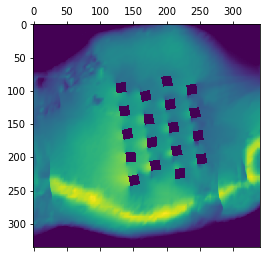

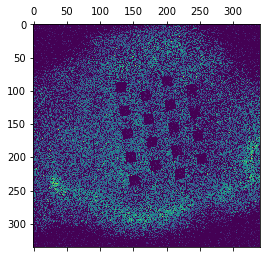

In [11]:
test_set = timesteps[train_size:]

test_raw = train_set[5, 0]
test = torch.Tensor(test_raw.flatten())
shp = test_set[5, 0].shape

compressed = autoencoder.get_compressed(test)
img = autoencoder(torch.Tensor(test))

img = img.detach().numpy()

# Plot
#plt.title("Original")
plt.matshow(test_raw)

#plt.title("Reconstructed")
plt.matshow(img.reshape(shp[0], shp[1]))